In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import random
from typing import Literal, Mapping, Optional


In [59]:
def read_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

x_train = read_images(r"C:\Users\omid\OneDrive\Desktop\train-images.idx3-ubyte")
y_train = read_labels(r"C:\Users\omid\OneDrive\Desktop\train-labels.idx1-ubyte")

x_test = read_images(r"C:\Users\omid\OneDrive\Desktop\t10k-images.idx3-ubyte")
y_test = read_labels(r"C:\Users\omid\OneDrive\Desktop\t10k-labels.idx1-ubyte")

print("Train shape:", x_train.shape)
print("test shape:", x_test.shape)


Train shape: (60000, 28, 28)
test shape: (10000, 28, 28)


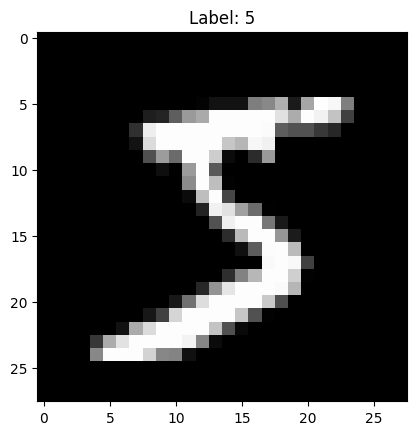

In [ ]:
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()


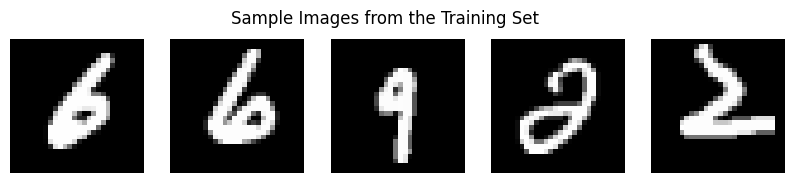

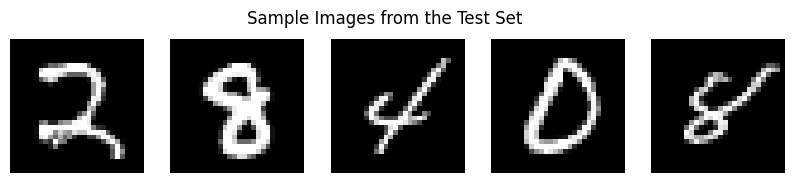

In [ ]:

# نمایش  تصاویر تصادفی از داده‌های آموزش
sample_train = random.sample(range(x_train.shape[0]), 5)
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, idx in enumerate(sample_train):
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].axis('off')
    #axes[i].set_title(f"Label: {y_train[idx]}")
plt.suptitle("Sample Images from the Training Set")
plt.show()

# نمایش  تصاویر تصادفی از داده‌های تست
sample_test = random.sample(range(x_test.shape[0]), 5)
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, idx in enumerate(sample_test):
    axes[i].imshow(x_test[idx], cmap='gray')
    axes[i].axis('off')
    #axes[i].set_title(f"Label: {y_test[idx]}")
plt.suptitle("Sample Images from the Test Set")
plt.show()


#  Filtering the Dataset for Binary Classification (Digits 2 and 5)

In [4]:
train_filter = np.where((y_train == 2) | (y_train == 5))
test_filter = np.where((y_test == 2) | (y_test == 5))

x_train_filtered = x_train[train_filter]
y_train_filtered = y_train[train_filter]
x_test_filtered = x_test[test_filter]
y_test_filtered = y_test[test_filter]


# Mapping Labels for Binary Classification (2 → 0, 5 → 1)

In [ ]:
y_train_filtered = (y_train_filtered == 5).astype(int)
y_test_filtered = (y_test_filtered == 5).astype(int)


# Flattening and Normalizing the Images

In [ ]:
x_train_flat = x_train_filtered.reshape(x_train_filtered.shape[0], -1) / 255.0
x_test_flat = x_test_filtered.reshape(x_test_filtered.shape[0], -1) / 255.0


# logistic regression

In [ ]:
class LogisticRegression:
    def __init__(
        self,
        penalty: Optional[Literal['l1', 'l2', 'elasticnet']] = "l2",
        dual: bool = False,
        tol: float = 0.0001,
        C: float = 1,
        fit_intercept: bool = True,
        intercept_scaling: float = 1,
        class_weight: Optional[Mapping] = None,
        random_state: Optional[int] = None,
        solver: Literal['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] = "lbfgs",
        max_iter: int = 100,
        multi_class: Literal['auto', 'ovr', 'multinomial'] = "auto",
        verbose: int = 0,
        warm_start: bool = False,
        n_jobs: Optional[int] = None,
        l1_ratio: Optional[float] = None
    ):
        self.penalty = penalty
        self.dual = dual
        self.tol = tol
        self.C = C
        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.class_weight = class_weight
        self.random_state = random_state
        self.solver = solver
        self.max_iter = max_iter
        self.multi_class = multi_class
        self.verbose = verbose
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.l1_ratio = l1_ratio
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def loss_function(self, y_true, y_pred):
        epsilon = 1e-8  
        return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for epoch in range(self.max_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # آپدیت وزن‌ها و بایاس
            self.weights -= self.C * dw
            self.bias -= self.C * db
            
            # محاسبه تابع هزینه برای نمایش پیشرفت آموزش
            if epoch % 100 == 0:
                loss = self.loss_function(y, y_pred)

        return self

    def predict(self, X):
        y_pred_prob = self.sigmoid(np.dot(X, self.weights) + self.bias)
        return (y_pred_prob >= 0.5).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)



In [51]:
# نمونه‌سازی مدل
model = LogisticRegression(max_iter=200)

# آموزش مدل با داده‌های آموزشی
model.fit(x_train_flat, y_train_filtered)

# پیش‌بینی با داده‌های تست
y_pred = model.predict(x_test_flat)


# Evaluating Classification Metrics: Accuracy, Precision, Recall, and F1 Score

In [49]:
def evaluate_metrics(y_true, y_pred_prob):
    """
    محاسبه معیارهای ارزیابی مدل: دقت (Accuracy)، دقت پیش‌بینی (Precision)، یادآوری (Recall) و امتیاز F1
    """
    # پیش‌بینی‌های باینری
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # تعداد TP, TN, FP, FN
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True Negatives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives

    # دقت (Accuracy)
    accuracy = (tp + tn) / len(y_true)

    # دقت پیش‌بینی (Precision)
    precision = tp / (tp + fp + 1e-8)  # جلوگیری از تقسیم بر صفر

    # یادآوری (Recall)
    recall = tp / (tp + fn + 1e-8)  # جلوگیری از تقسیم بر صفر

    # امتیاز F1 (F1-Score)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # جلوگیری از تقسیم بر صفر

    return accuracy, precision, recall, f1


In [50]:
accuracy, precision, recall, f1 = evaluate_metrics(y_test_filtered, y_pred)
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")


Test Accuracy: 0.9792
Test Precision: 0.9733
Test Recall: 0.9821
Test F1-Score: 0.9777
